# Policy Optimization - the control problem of RL

### Legacy repo does not work with gymnasium so some installs and hacks are needed

In [2]:
#!pip install git+https://github.com/mimoralea/gym-walk#egg=gym-walk

In [1]:
#!pip install gym_walk
#!pip install gymnasium

In [1]:
#import numpy as np
#import gymnasium as gym, gym_walk
#import gymnasium as gym
#from gym_walk.envs import WalkEnv

In [2]:
#from gymnasium.envs.registration import register

In [3]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.0},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [4]:
#register(
#    # One non-terminal states and two terminal
#    # Technically speaking, this is a bandit MDP
#    id='BanditSlipperyWalk-v0',
#    entry_point='gym_walk.envs:WalkEnv',
#    # left-most and right-most states are terminal
#    kwargs={'n_states': 1, 'p_stay': 0.0, 'p_backward': 0.2},
#    max_episode_steps=100,
#    reward_threshold=1.0,
#    nondeterministic=True,
#)

In [5]:
## (Stochastic) Markov Decission Problem: MDP
## s a (p(a|s), s', r, Teminal?)
#P = {
#    0: {
#        0: [(1.0, 0, 0.0, True)],
#        1: [(1.0, 0, 0.0, True)]
#    },
#    1: {
#        0: [(0.8, 0, 0.0, True), (0.2, 2, 1.0, True)],
#        1: [(0.8, 2, 1.0, True), (0.2, 0, 0.0, True)]
#    },
#    2: {
#        0: [(1.0, 2, 0.0, True)],
#        1: [(1.0, 2, 0.0, True)]
#    }
#}

In [6]:
#env = gym.make('BanditWalk-v0')

# Environment setup

### Upon installing gym_walk lib one can actuall directly instantiate envs used in the book by using proper env parameters

In [1]:
import numpy as np
from gym_walk.envs import WalkEnv

from tqdm import tqdm
import matplotlib.pyplot as plt

from itertools import count

### Slippery walk 1D AKA two-arm stochastic bandid

In [2]:
env = WalkEnv(n_states=7, p_stay=0.33, p_backward=0.16)

In [3]:
env.P

{0: {0: [(0.5099999999999999, 0, 0.0, True),
   (0.33, 0, 0.0, True),
   (0.16, 1, 0.0, False)],
  1: [(0.5099999999999999, 1, 0.0, False),
   (0.33, 0, 0.0, True),
   (0.16, 0, 0.0, True)]},
 1: {0: [(0.5099999999999999, 0, 0.0, True),
   (0.33, 1, 0.0, False),
   (0.16, 2, 0.0, False)],
  1: [(0.5099999999999999, 2, 0.0, False),
   (0.33, 1, 0.0, False),
   (0.16, 0, 0.0, True)]},
 2: {0: [(0.5099999999999999, 1, 0.0, False),
   (0.33, 2, 0.0, False),
   (0.16, 3, 0.0, False)],
  1: [(0.5099999999999999, 3, 0.0, False),
   (0.33, 2, 0.0, False),
   (0.16, 1, 0.0, False)]},
 3: {0: [(0.5099999999999999, 2, 0.0, False),
   (0.33, 3, 0.0, False),
   (0.16, 4, 0.0, False)],
  1: [(0.5099999999999999, 4, 0.0, False),
   (0.33, 3, 0.0, False),
   (0.16, 2, 0.0, False)]},
 4: {0: [(0.5099999999999999, 3, 0.0, False),
   (0.33, 4, 0.0, False),
   (0.16, 5, 0.0, False)],
  1: [(0.5099999999999999, 5, 0.0, False),
   (0.33, 4, 0.0, False),
   (0.16, 3, 0.0, False)]},
 5: {0: [(0.50999999999999

In [4]:
env.reset()

(4, {'prob': 1.0})

In [5]:
env.step(1)

(5, 0.0, False, False, {'prob': 0.5099999999999999, 'success': False})

## MC policy evaluation

In [6]:
env.action_space

Discrete(2)

In [7]:
env.action_space.n

2

In [8]:
# 10^{-3...0} every 1/10, so we get 10 points of 10 raised to linear space power in the range [-3, 0]
np.logspace(-2, 0, 10, base=10, endpoint=True)

array([0.01      , 0.01668101, 0.02782559, 0.04641589, 0.07742637,
       0.12915497, 0.21544347, 0.35938137, 0.59948425, 1.        ])

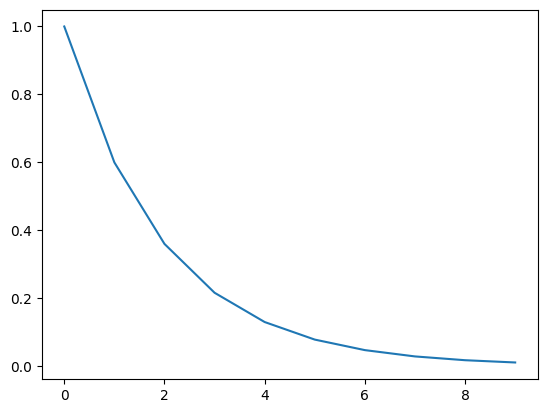

In [94]:
plt.plot(np.logspace(-2, 0, 10, base=10, endpoint=True)[::-1])

In [5]:
def decay_schedule(init_value,
                   min_value,
                   decay_ratio,
                   max_steps,
                   log_start=-2,
                   log_base=10):
    
    decay_steps = int(decay_ratio * max_steps)
    rem_steps = max_steps - decay_steps
    values = np.logspace(log_start, 0, decay_steps, base=log_base, endpoint=True)[::-1]
    values = (values - values.min())/(values.max() - values.min())
    values = (init_value - min_value) * values + min_value
    # padding (0, rem_steps) padds 0 elements on the left and rem_steps elements on the right, with edge value
    values = np.pad(values, (0, rem_steps), 'edge')
    
    return values

In [23]:
# Generate a single experience trajectory passing an episode up to done or max_steps limit
def generate_trajectory(select_action, Q, epsilon, env, max_steps=200):
    done, trajectory = False, []
    while not done:
        state = env.reset()[0] # There was no [0] in the Grokking RL book
        for t in count():
            # In control problem we allow for a more generic action selection
            action = select_action(state, Q, epsilon)
            # Typical step return value for walk-5:
            # (5, 0.0, False, False, {'prob': 0.5, 'success': False})
            next_state, reward, done, _ , _= env.step(action)
            experience = (state, action, reward, next_state, done)
            trajectory.append(experience)
            if done:
                break
            if t >= max_steps - 1:
                trajectory = []
                break
            state = next_state

    return np.array(trajectory, 'object')

In [24]:
def mc_control(env,
               gamma=1.0,
               init_alpha=0.5,
               min_alpha=0.01,
               alpha_decay_ratio=0.3,
               init_epsilon=0.5,
               min_epsilon=0.01,
               epsilon_decay_ratio=0.9,
               n_episodes=3000,
               max_steps=200,
               first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    discounts = np.logspace(0, max_steps, num=max_steps, base=gamma, endpoint=False)
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if epsilon > np.random.random() else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        trajectory = generate_trajectory(select_action, Q, epsilons[e], env, max_steps)
        visited = np.zeros((nS, nA), dtype='bool')
        # Original line in the book has the unused reward element
        #for t, (state, _, reward, _, _) in enumerate(trajectory):
        for t, (state, action, reward, _, _) in enumerate(trajectory):
            if visited[state][action] and first_visit:
                continue
            visited[state][action] = True
            n_steps = len(trajectory[t:])
            G = np.sum(discounts[:n_steps] * trajectory[t:, 2])
            Q[state][action] = Q[state][action] + alphas[e] * (G - Q[state][action])
            
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track
        

In [25]:
Q_s, V_t, pi, Q_track, pi_track = mc_control(env)

In [26]:
Q_s.shape

(9, 2)

In [27]:
Q_s

array([[0.        , 0.        ],
       [0.08033208, 0.16052809],
       [0.22505125, 0.27887668],
       [0.33302876, 0.4145802 ],
       [0.4495342 , 0.53633073],
       [0.56183527, 0.6515299 ],
       [0.69735512, 0.79191911],
       [0.83734996, 0.92494624],
       [0.        , 0.        ]])

In [21]:
V_t

array([0.        , 0.2126048 , 0.29814423, 0.41042915, 0.58343454,
       0.69777941, 0.80416476, 0.89827679, 0.        ])

In [22]:
Q_track.shape

(3000, 9, 2)

In [25]:
pi_track[0].shape

(9,)

In [28]:
Q_track[:,0,0].shape

(3000,)

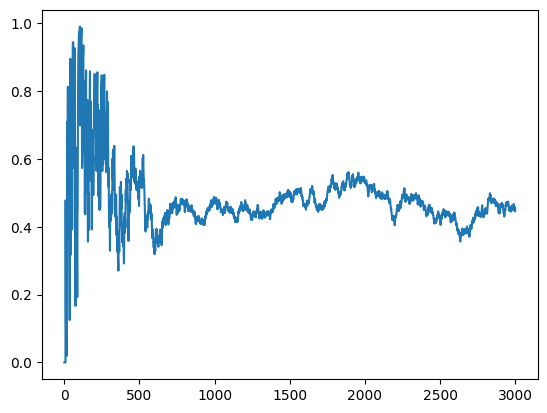

In [30]:
plt.plot(Q_track[:, 4, 0])

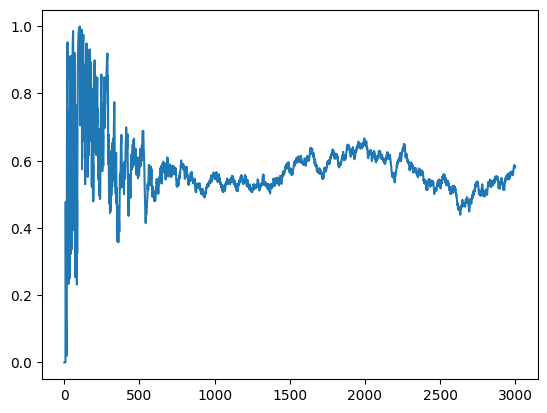

In [31]:
plt.plot(Q_track[:, 4, 1])

## TD Learning - less variance and more sample efficient estimation

In [90]:
v_s, v_t = td_lambda(pi, env)

In [91]:
v_s

array([0.        , 0.12276795, 0.30122835, 0.47160785, 0.65002088,
       0.82679418, 0.        ])

## SARSA

In [17]:
def sarsa(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=6000,
          first_visit=True):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset()[0], False
        action = select_action(state, Q, epsilons[e])
    
        while not done:
            next_state, reward, done, _, _ = env.step(action)
            next_action = select_action(next_state, Q, epsilons[e])
            td_target = reward + gamma * Q[next_state][next_action] * (not done)
            td_error = td_target - Q[state][action]
            
            Q[state][action] = Q[state][action] + alphas[e] * td_error
            state, acton = next_state, next_action
            
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

In [18]:
Q_s, V_t, pi, Q_track, pi_track = sarsa(env)

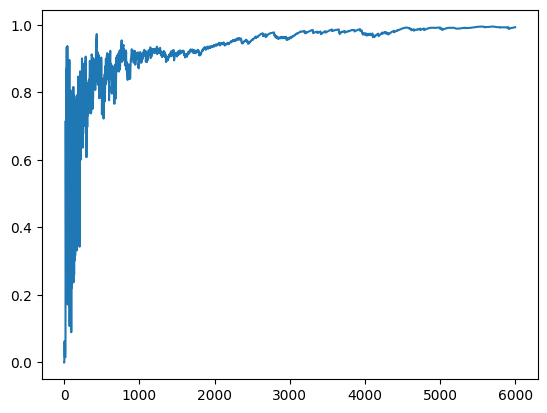

In [19]:
plt.plot(Q_track[:, 6, 1])

In [20]:
V_t

array([0.        , 0.51021857, 0.83308684, 0.93834752, 0.97217473,
       0.98636167, 0.99263674, 0.99736404, 0.        ])

## Q-learning, an off-policy control optimization
### As seen by the different  run hyperparameters Q-learning converges much faster than SARSA (in this env at least)

In [27]:
def q_learning(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q = np.zeros((nS, nA), dtype=np.float64)
    Q_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset()[0], False
    
        while not done:
            action = select_action(state, Q, epsilons[e])
            next_state, reward, done, _, _ = env.step(action)
            td_target = reward + gamma * Q[next_state].max() * (not done)
            td_error = td_target - Q[state][action]
            Q[state][action] += alphas[e] * td_error
            state = next_state
            
        Q_track[e] = Q
        pi_track.append(np.argmax(Q, axis=1))
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, Q_track, pi_track

In [28]:
Q_s, V_t, pi, Q_track, pi_track = q_learning(env)

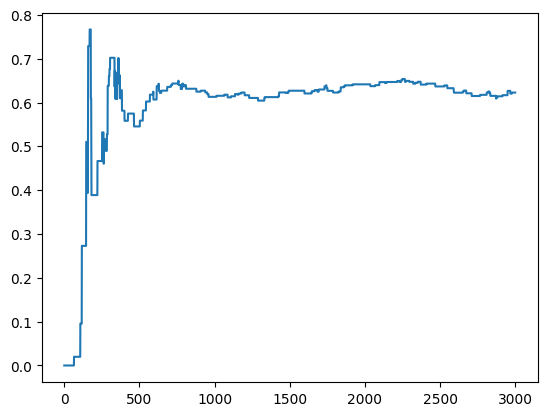

In [29]:
plt.plot(Q_track[:, 1, 1])

In [21]:
V_t

array([0.        , 0.51021857, 0.83308684, 0.93834752, 0.97217473,
       0.98636167, 0.99263674, 0.99736404, 0.        ])

## Double Q-learning: avoiding value overestimation
### Curing maximization bias by separating exploration policy from estimation policy 

In [22]:
def double_q_learning(env,
          gamma=1.0,
          init_alpha=0.5,
          min_alpha=0.01,
          alpha_decay_ratio=0.3,
          init_epsilon=0.5,
          min_epsilon=0.01,
          epsilon_decay_ratio=0.9,
          n_episodes=3000):
    nS, nA = env.observation_space.n, env.action_space.n
    alphas = decay_schedule(init_alpha, min_alpha, alpha_decay_ratio, n_episodes)
    epsilons = decay_schedule(init_epsilon, min_epsilon, epsilon_decay_ratio, n_episodes)

    pi_track = []
    Q1 = np.zeros((nS, nA), dtype=np.float64)
    Q1_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)
    Q2 = np.zeros((nS, nA), dtype=np.float64)
    Q2_track = np.zeros((n_episodes, nS, nA), dtype=np.float64)

    select_action = lambda state, Q, epsilon: \
        np.argmax(Q[state]) if np.random.random() > epsilon else np.random.choice(len(Q[state]))
    
    for e in tqdm(range(n_episodes), leave=False):
        state, done = env.reset()[0], False

        while not done:
            action = select_action(state, (Q1 + Q2)/2., epsilons[e])
            next_state, reward, done, _, _ = env.step(action)
            
            if np.random.randint(2):
                argmax_Q1 = np.argmax(Q1[next_state])
                td_target = reward + gamma * Q2[next_state].max() * (not done)
                td_error = td_target - Q2[state][action]
                Q2[state][action] += alphas[e] * td_error
            else:
                argmax_Q2 = np.argmax(Q2[next_state])
                td_target = reward + gamma * Q1[next_state].max() * (not done)
                td_error = td_target - Q1[state][action]
                Q1[state][action] += alphas[e] * td_error
            
            state = next_state
            
        Q1_track[e] = Q1
        Q2_track[e] = Q2
        pi_track.append(np.argmax((Q1 + Q2)/2., axis=1))

    Q = (Q1 + Q2)/2.
    V = np.max(Q, axis=1)
    pi = lambda s: {s:a for s, a in enumerate(np.argmax(Q, axis=1))}[s]
    
    return Q, V, pi, (Q1_track + Q2_track)/2., pi_track

In [23]:
Q_s, V_t, pi, Q_track, pi_track = double_q_learning(env)

In [24]:
V_t

array([0.        , 0.65224687, 0.89766322, 0.97246202, 0.99158654,
       0.99741752, 0.99926036, 0.99981825, 0.        ])

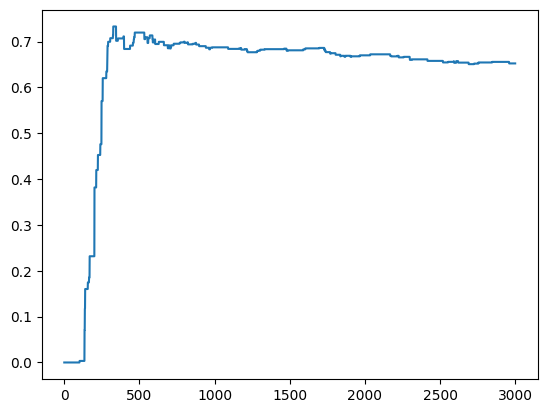

In [26]:
plt.plot(Q_track[:, 1, 1])